In [2]:
!spacy download en_core_web_md

import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.0.0/en_core_web_md-3.0.0-py3-none-any.whl (47.1 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [9]:
df = pd.read_csv("data/intent-classification-training-data.csv").loc[:,["Question","Large Category"]]
display(df.sample(5))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

,Question,Large Category
0,How big of a disaster are the current Californ...,Current Fire Information
1,What cant a fire extinguisher put out?,Emergency Fire Protocols
2,My house is on fire what do I do?!!?,Emergency Fire Protocols
3,Can you use a fire extinguisher to put out a g...,Emergency Fire Protocols
4,How can you stop electrical fires?,Emergency Fire Protocols


In [4]:
class TextVectorizer(TransformerMixin):
    
    def transform(self, X, **transform_params):
        nlp = spacy.load('en_core_web_md')
        new_X = np.zeros((len(X), nlp.vocab.vectors_length))
        # Iterate over the sentences
        for idx, sentence in enumerate(X):
            # Pass each sentence to the nlp object to create a document
            doc = nlp(sentence)
            # Save the document's .vector attribute to the corresponding row in     
            # X
            new_X[idx, :] = doc.vector
        return new_X
    
    def fit(self, X, y=None, **fit_params):
        return self

In [11]:
pipe = Pipeline([("Spacy_Vectorizer", TextVectorizer()),
                 ('Classifier',  LogisticRegression(solver='lbfgs', max_iter=7600))])

In [12]:
pipe.fit(df_train["Question"], df_train["Large Category"])

Pipeline(steps=[('Spacy_Vectorizer',
                 <__main__.TextVectorizer object at 0x7f31aa8c6940>),
                ('Classifier', LogisticRegression(max_iter=7600))])

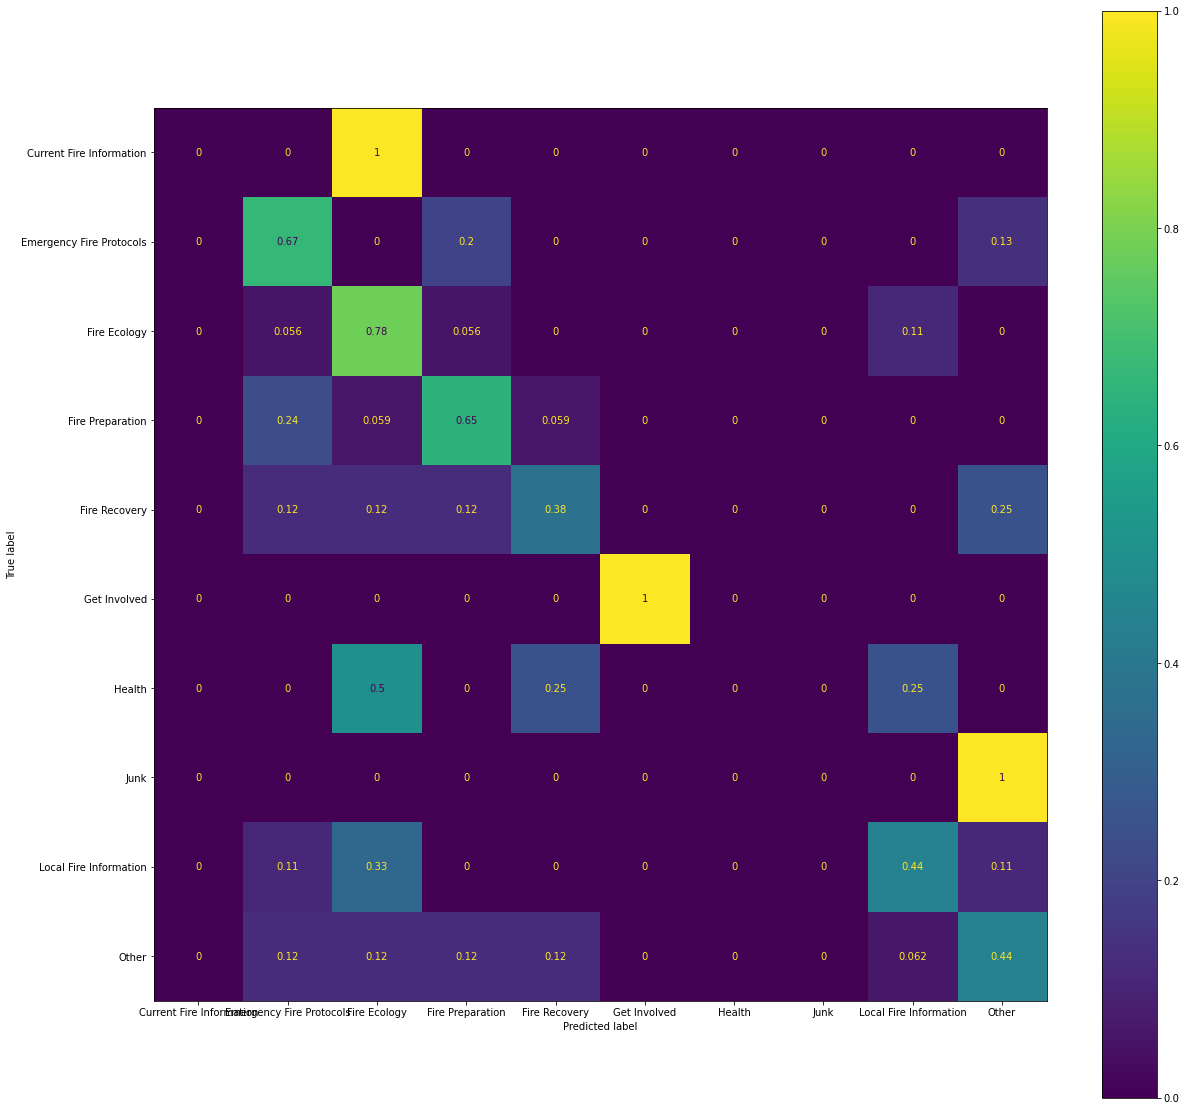

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(pipe, df_test.Question, df_test["Large Category"], normalize='true', ax=ax);

In [10]:
scores = cross_val_score(pipe, X=df_train.Question, y=df_train["Large Category"], cv=5)

/home/jack/miniconda3/envs/firewatch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
